<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#Catboost" data-toc-modified-id="Catboost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Catboost</a></span></li><li><span><a href="#LightGBMRegressor" data-toc-modified-id="LightGBMRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LightGBMRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [ ]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('/datasets/taxi.csv')

# выведем первые 5 строчек датафрейма на экран
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [ ]:
# с помощью метода info() изучим структуры таблиц: типы данных, количество строк, столбцов, пропущенных данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [ ]:
# изменим тип данных datetime с object на datetime64 и установим индекс таблицы равным столбцу datetime
df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col='datetime')

# проверим
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [ ]:
# Убедимся, что даты и время расположены в хронологическом порядке
df.index.is_monotonic

True

In [ ]:
# выполним ресемплирование данных по одному часу
df = df.resample('1H').sum()
display(df.head())
df.info()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Анализ

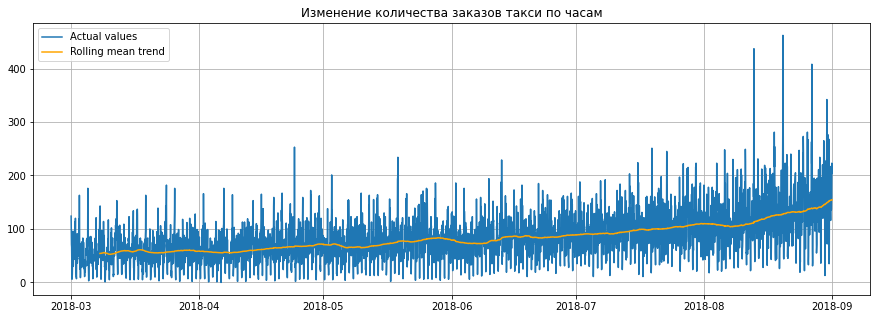

In [ ]:
# выведем график изменения данных
rolling_mean = df.rolling(24*7).mean()

plt.figure(figsize=(15,5))
plt.title("Изменение количества заказов такси по часам")

plt.plot(df, label="Actual values")
plt.plot(rolling_mean, "g", label="Rolling mean trend", color='orange')
plt.legend(loc="upper left")
plt.grid(True)

*По скользящему среднему с размером окна в 1 неделю мы видим, что происходит непрерывный рост количества заказов такси.*

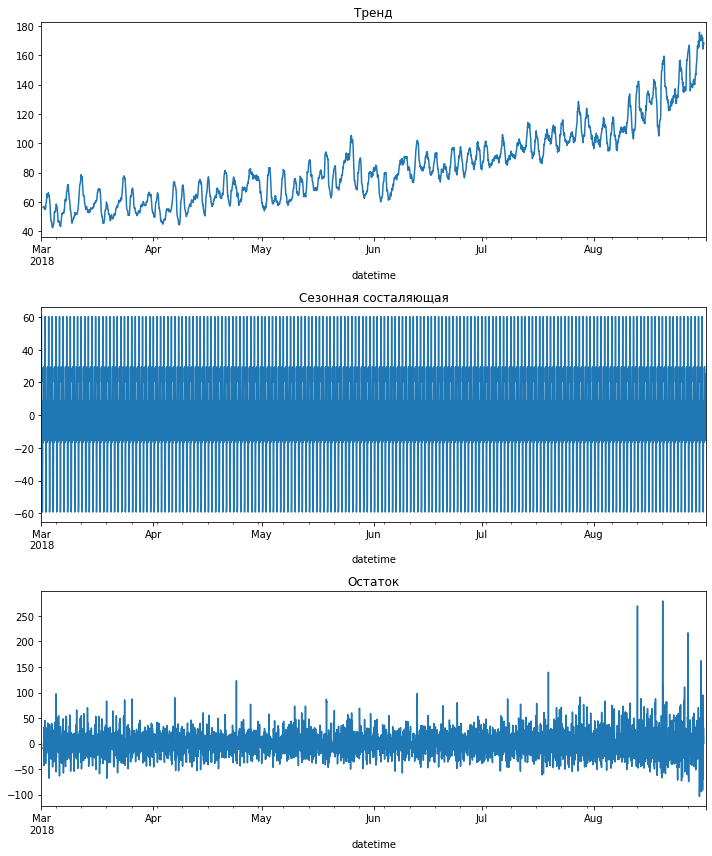

In [ ]:
# разложим временной ряд на тренд и сезоную составляющие
decomposed = seasonal_decompose(df)

plt.figure(figsize=(10, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонная состаляющая')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.tight_layout()

*График сезонности скорей всего показывает сезонность внутри периода. Посмотрим его детальнее.*

<AxesSubplot:title={'center':'Сезонность заказов в течение 3-х недель'}, xlabel='datetime'>

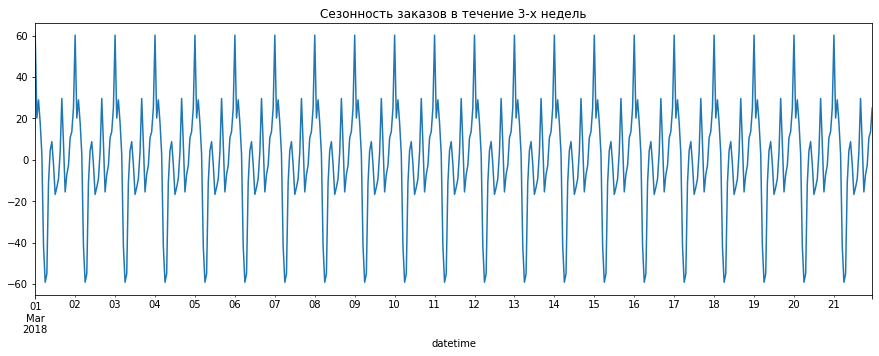

In [ ]:
plt.figure(figsize=(15,5))
plt.title("Сезонность заказов в течение 3-х недель")
decomposed.seasonal['2018-03-01':'2018-03-21'].plot(ax=plt.gca())

In [ ]:
# выполним ресемплирование данных по одному дню
df_week = df.resample('1D').sum()
decomposed_week = seasonal_decompose(df_week)

<AxesSubplot:title={'center':'Сезонность заказов в течение 3-х недель'}, xlabel='datetime'>

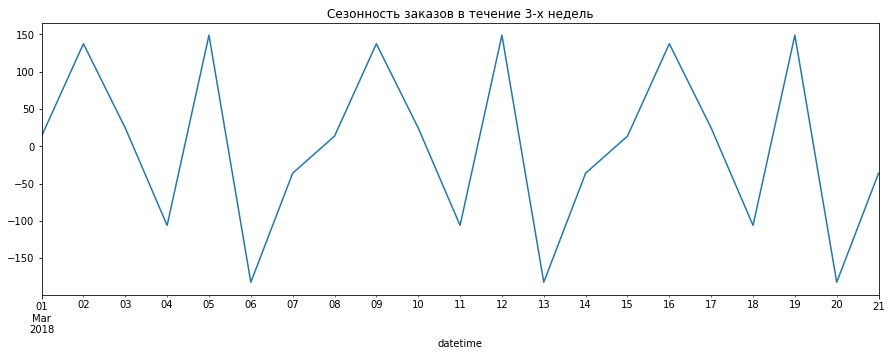

In [ ]:
plt.figure(figsize=(15,5))
plt.title("Сезонность заказов в течение 3-х недель")
decomposed_week.seasonal['2018-03-01':'2018-03-21'].plot(ax=plt.gca())

*График тренда подтвердил возрастающую зависимость. График сезонности показывает сезонность внутри одного дня и недели:*
* по дню пик приходится на полночь и спад перед утренними часами.
* по неделе пик на понедельник и пятницу.

*Временной ряд в таком виде не является стационарным, так как подвержен тренду, который меняется во времени и имеет сезонности.*

*Пропусков в данных нет, предобработка данных не требуется. Приступим к обкчению модели.*

## Обучение

*Создадим дополнительные признаки для последующего обучения моделей.*

*Так как стоит задача краткосрочного прогноза (на час вперед), то такие признаки как день недели, месяц и год включать не будем.*

*Мы делаем прогноз на сутки, поэтому скользящее среднее равно 24 часам.*


In [ ]:
def make_features(data, max_lag, rolling_mean_size):

    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek


    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [ ]:
df_1 = make_features(df, 2, 24)
df_1.head(10)

,num_orders,hour,dayofweek,lag_1,lag_2,rolling_mean
datetime,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN
2018-03-01 02:00:00,71,2,3,85.0,124.0,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,NaN
2018-03-01 04:00:00,43,4,3,66.0,71.0,NaN
2018-03-01 05:00:00,6,5,3,43.0,66.0,NaN
2018-03-01 06:00:00,12,6,3,6.0,43.0,NaN
2018-03-01 07:00:00,15,7,3,12.0,6.0,NaN
2018-03-01 08:00:00,34,8,3,15.0,12.0,NaN


*Разделим данные на обучающую и тестовые выборки и проверим корректность деления.*

In [ ]:
train, test = train_test_split(df_1, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop('num_orders',axis=1)
features_test = test.drop('num_orders',axis=1)
target_train = train['num_orders']
target_test = test['num_orders']

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-02 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [ ]:
# уберем пропуски в train
train.dropna(inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3950 entries, 2018-03-02 00:00:00 to 2018-08-13 13:00:00
Freq: H
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    3950 non-null   int64  
 1   hour          3950 non-null   int64  
 2   dayofweek     3950 non-null   int64  
 3   lag_1         3950 non-null   float64
 4   lag_2         3950 non-null   float64
 5   rolling_mean  3950 non-null   float64
dtypes: float64(3), int64(3)
memory usage: 216.0 KB


In [ ]:
# выделим обучающие признаки и целевые признаки в выборках

features_train = train.drop('num_orders', axis = 1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis = 1)
target_test = test['num_orders']

print(features_train.shape, target_train.shape)
print(features_test.shape, target_test.shape)

(3950, 5) (3950,)
(442, 5) (442,)


*Проведем обучение моделей LinearRegression, DecisionTreeRegressor, CatBoostRegressor и LGBMRegressor.*

### LinearRegression

In [ ]:
model_lr = LinearRegression()

parameters = {'fit_intercept':[True,False], 'normalize':[True,False]}
grid = RandomizedSearchCV(model_lr, parameters, cv=TimeSeriesSplit(n_splits=5), scoring='neg_root_mean_squared_error', verbose=5, n_jobs=-1)
grid.fit(features_train, target_train)

RMSE_lr_train=-grid.best_score_

print('Наилучшие параметры для LinearRegression:', grid.best_params_)
print('RMSE LinearRegression на обучающей выборке:', RMSE_lr_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .............fit_intercept=True, normalize=True; total time=   0.0s
[CV 2/5] END .............fit_intercept=True, normalize=True; total time=   0.0s
[CV 3/5] END .............fit_intercept=True, normalize=True; total time=   0.0s
[CV 4/5] END .............fit_intercept=True, normalize=True; total time=   0.0s
[CV 5/5] END .............fit_intercept=True, normalize=True; total time=   0.0s
[CV 1/5] END ............fit_intercept=True, normalize=False; total time=   0.0s
[CV 2/5] END ............fit_intercept=True, normalize=False; total time=   0.0s
[CV 3/5] END ............fit_intercept=True, normalize=False; total time=   0.0s
[CV 4/5] END ............fit_intercept=True, normalize=False; total time=   0.0s
[CV 5/5] END ............fit_intercept=True, normalize=False; total time=   0.0s
[CV 1/5] END ............fit_intercept=False, normalize=True; total time=   0.0s
[CV 2/5] END ............fit_intercept=False, nor

### RandomForestRegressor

In [ ]:
model_rfr = RandomForestRegressor(random_state=12345)

params = {'n_estimators': range(30, 151, 10),
                 'max_depth': range(1,15)}

forest_grid = RandomizedSearchCV(model_rfr, params, cv=TimeSeriesSplit(n_splits=5),
                                 scoring='neg_root_mean_squared_error', verbose=5, n_jobs=-1)
forest_grid.fit(features_train, target_train)

RMSE_rfr_train = -forest_grid.best_score_

print('RMSE RandomForestRegressor на обучающей выборке:', RMSE_rfr_train)

print('Наилучшие параметры для RandomForestRegressor:', forest_grid.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ...................max_depth=3, n_estimators=40; total time=   0.1s
[CV 2/5] END ...................max_depth=3, n_estimators=40; total time=   0.1s
[CV 3/5] END ...................max_depth=3, n_estimators=40; total time=   0.1s
[CV 4/5] END ...................max_depth=3, n_estimators=40; total time=   0.1s
[CV 5/5] END ...................max_depth=3, n_estimators=40; total time=   0.1s
[CV 1/5] END .................max_depth=12, n_estimators=120; total time=   0.3s
[CV 2/5] END .................max_depth=12, n_estimators=120; total time=   0.4s
[CV 3/5] END .................max_depth=12, n_estimators=120; total time=   0.6s
[CV 4/5] END .................max_depth=12, n_estimators=120; total time=   0.9s
[CV 5/5] END .................max_depth=12, n_estimators=120; total time=   1.0s
[CV 1/5] END ...................max_depth=2, n_estimators=90; total time=   0.1s
[CV 2/5] END ...................max_depth=2, n_e

### Catboost

In [ ]:
model_cbr = CatBoostRegressor(loss_function="RMSE")
grid = {
    'learning_rate': [0.03, 0.1, 0.5],
    'iterations': [100, 200]
}

cbr_grid = RandomizedSearchCV(model_cbr, grid,
                         cv=TimeSeriesSplit(n_splits=5), verbose=5, scoring='neg_root_mean_squared_error')

cbr_grid.fit(features_train, target_train)

RMSE_cbr_train = -cbr_grid.best_score_
print('RMSE для CatBoostRegressor на обучающей выборке:', RMSE_cbr_train)

print('Наилучшие параметры для CatBoostRegressor:', cbr_grid.best_params_)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
0:	learn: 29.3002050	total: 1.11ms	remaining: 110ms
1:	learn: 28.9268121	total: 2.26ms	remaining: 111ms
2:	learn: 28.5272087	total: 3.35ms	remaining: 108ms
3:	learn: 28.1983498	total: 4.41ms	remaining: 106ms
4:	learn: 27.7659849	total: 5.44ms	remaining: 103ms
5:	learn: 27.4416189	total: 6.5ms	remaining: 102ms
6:	learn: 27.0596999	total: 7.56ms	remaining: 100ms
7:	learn: 26.7119866	total: 8.63ms	remaining: 99.3ms
8:	learn: 26.3869301	total: 9.75ms	remaining: 98.6ms
9:	learn: 26.0702913	total: 10.7ms	remaining: 96.6ms
10:	learn: 25.7953840	total: 11.8ms	remaining: 95.1ms
11:	learn: 25.4844962	total: 12.8ms	remaining: 93.7ms
12:	learn: 25.2118500	total: 13.8ms	remaining: 92.1ms
13:	learn: 24.9766536	total: 14.8ms	remaining: 91ms
14:	learn: 24.6954338	total: 15.7ms	remaining: 89.2ms
15:	learn: 24.4456530	total: 16.7ms	remaining: 87.6ms
16:	learn: 24.1742434	total: 19.4ms	remaining: 94.7ms
17:	learn: 23.8973968	total: 20.5ms	remain

### LightGBMRegressor

In [ ]:
model_gbm = LGBMRegressor(random_state=12345)

params = {'n_estimators': [50, 100, 200],
              'num_leaves': [21, 31, 41],
              'learning_rate':[0.01, .04, 0.06]}

g_grid = RandomizedSearchCV(model_gbm, params,
                         cv=TimeSeriesSplit(n_splits=5), verbose=5, scoring='neg_root_mean_squared_error')
g_grid.fit(features_train, target_train)
RMSE_gbm_train = -g_grid.best_score_
print('RMSE для LGBMRegressor на обучающей выборке', RMSE_gbm_train)

print('Наилучшие параметры для LGBMRegressor:', g_grid.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END learning_rate=0.04, n_estimators=50, num_leaves=21; total time= 1.6min
[CV 2/5] END learning_rate=0.04, n_estimators=50, num_leaves=21; total time= 2.1min
[CV 3/5] END learning_rate=0.04, n_estimators=50, num_leaves=21; total time= 1.8min
[CV 4/5] END learning_rate=0.04, n_estimators=50, num_leaves=21; total time= 1.8min
[CV 5/5] END learning_rate=0.04, n_estimators=50, num_leaves=21; total time= 1.8min
[CV 1/5] END learning_rate=0.01, n_estimators=50, num_leaves=31; total time= 1.7min
[CV 2/5] END learning_rate=0.01, n_estimators=50, num_leaves=31; total time= 2.4min
[CV 3/5] END learning_rate=0.01, n_estimators=50, num_leaves=31; total time= 2.5min
[CV 4/5] END learning_rate=0.01, n_estimators=50, num_leaves=31; total time= 3.1min
[CV 5/5] END learning_rate=0.01, n_estimators=50, num_leaves=31; total time= 3.3min
[CV 1/5] END learning_rate=0.01, n_estimators=100, num_leaves=31; total time= 3.6min
[CV 2/5] END l

In [ ]:
list_train = (RMSE_lr_train, RMSE_rfr_train, RMSE_cbr_train, RMSE_gbm_train)

df_rmse=pd.DataFrame(list_train,
                           index=['LinearRegression',
                                  'RandomForestRegressor',
                                  'CatBoostRegressor',
                                  'LGBMRegressor'],
                           columns = ['RMSE'])
df_rmse

,RMSE
LinearRegression,31.742917
RandomForestRegressor,25.287766
CatBoostRegressor,25.269630
LGBMRegressor,25.156490


*Таким образом мы получили минимальную метрику RSME при обучении модели методом CatBoostRegressor.*

## Тестирование

*Определим RSME на тестовых данных с подобранными гиперпараметрами.*

*LinearRegression*

In [ ]:
model_lr = LinearRegression(normalize = True, fit_intercept = False)

model_lr_test = model_lr.fit(features_train,target_train)

predict_lr_test = model_lr_test.predict(features_test)

RMSE_lr_test=np.sqrt(mean_squared_error(predict_lr_test, target_test))
print('RMSE LinearRegression на тестовой выборке:', RMSE_lr_test)

RMSE LinearRegression на тестовой выборке: 51.192444258655904


*Построим график для сравнения реальных значений и предсказанных.*

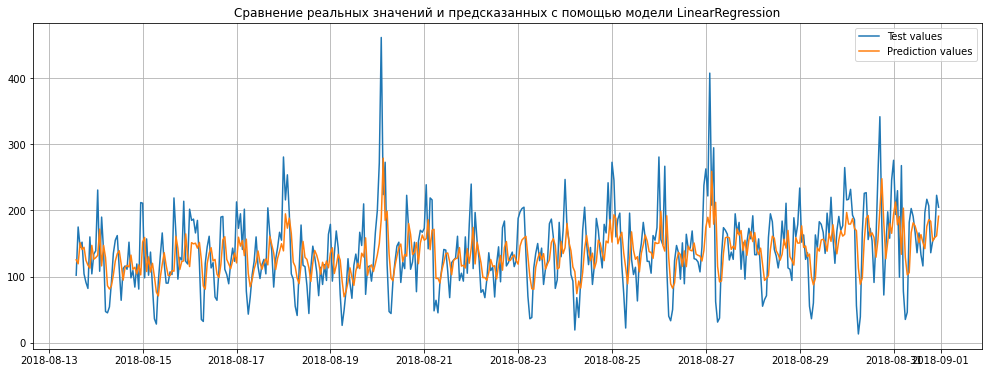

In [ ]:
plt.figure(figsize=(17, 6))
plt.title('Сравнение реальных значений и предсказанных с помощью модели LinearRegression')

plt.plot(target_test, label='Test values')
predictions = model_lr_test.predict(features_test)
predictions = pd.Series(predictions, index=target_test.index)
plt.plot(predictions, label ='Prediction values')

plt.legend(loc='upper right')
plt.grid(True)

*RandomForestRegressor*

In [ ]:
model_rfr_test = RandomForestRegressor(n_estimators=120, max_depth=12, random_state=12345)

model_rfr_test.fit(features_train,target_train)
predict_rfr_test = model_rfr_test.predict(features_test)

RMSE_rfr_test=np.sqrt(mean_squared_error(predict_rfr_test, target_test))
print('RMSE RandomForestRegressor на тестовой выборке:', RMSE_rfr_test)

RMSE RandomForestRegressor на тестовой выборке: 47.10642261627551


*Построим график для сравнения реальных значений и предсказанных.*

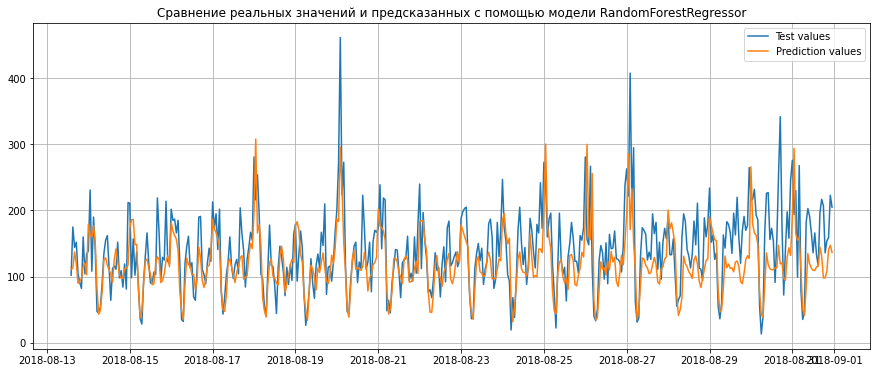

In [ ]:
plt.figure(figsize=(15, 6))
plt.title('Сравнение реальных значений и предсказанных с помощью модели RandomForestRegressor')
plt.plot(target_test, label='Test values')
predictions = model_rfr_test.predict(features_test)
predictions = pd.Series(predictions, index=target_test.index)
plt.plot(predictions, label ='Prediction values')
plt.legend(loc='upper right')
plt.grid(True)

*CatBoostRegressor*

In [ ]:
model_cbr_test = CatBoostRegressor(learning_rate=0.1, iterations=200, random_state=12345)

model_cbr_test.fit(features_train,target_train)

predict_cbr_test = model_cbr_test.predict(features_test)

RMSE_cbr_test=np.sqrt(mean_squared_error(predict_cbr_test, target_test))
print('RMSE CatBoostRegressor на тестовой выборке:', RMSE_cbr_test)

0:	learn: 36.9461515	total: 1.36ms	remaining: 272ms
1:	learn: 35.6351980	total: 2.96ms	remaining: 294ms
2:	learn: 34.4167789	total: 4.14ms	remaining: 272ms
3:	learn: 33.2019012	total: 5.33ms	remaining: 261ms
4:	learn: 32.0146058	total: 6.37ms	remaining: 248ms
5:	learn: 31.0379503	total: 7.45ms	remaining: 241ms
6:	learn: 30.3581430	total: 8.65ms	remaining: 239ms
7:	learn: 29.5546499	total: 9.82ms	remaining: 236ms
8:	learn: 28.9207051	total: 10.9ms	remaining: 231ms
9:	learn: 28.3566140	total: 11.9ms	remaining: 227ms
10:	learn: 27.9153031	total: 13.1ms	remaining: 225ms
11:	learn: 27.4157362	total: 14.2ms	remaining: 223ms
12:	learn: 27.0119722	total: 15.3ms	remaining: 220ms
13:	learn: 26.7163781	total: 16.4ms	remaining: 218ms
14:	learn: 26.3812128	total: 17.5ms	remaining: 216ms
15:	learn: 26.0915025	total: 18.7ms	remaining: 215ms
16:	learn: 25.8764124	total: 19.7ms	remaining: 213ms
17:	learn: 25.6039526	total: 20.8ms	remaining: 210ms
18:	learn: 25.4378767	total: 22ms	remaining: 209ms
19:	l

*Построим график для сравнения реальных значений и предсказанных.*

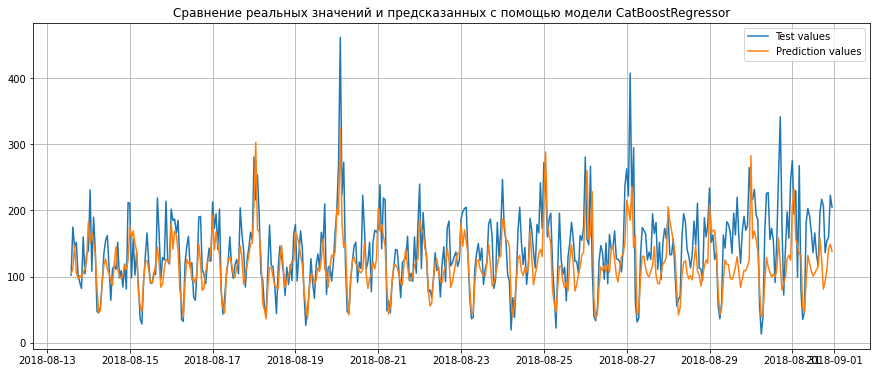

In [ ]:
plt.figure(figsize=(15, 6))
plt.title('Сравнение реальных значений и предсказанных с помощью модели CatBoostRegressor')
plt.plot(target_test, label='Test values')
predictions = model_cbr_test.predict(features_test)
predictions = pd.Series(predictions, index=target_test.index)
plt.plot(predictions, label ='Prediction values')
plt.legend(loc='upper right')
plt.grid(True)

*LGBMRegressor*

In [ ]:
model_gbm_test = LGBMRegressor(num_leaves=41, n_estimators=100, learning_rate=0.06, random_state=12345)

model_gbm_test.fit(features_train,target_train)

predict_gbm_test = model_gbm_test.predict(features_test)

RMSE_gbm_test=np.sqrt(mean_squared_error(predict_gbm_test, target_test))
print('RMSE LGBMRegressor на тестовой выборке:', RMSE_gbm_test)

RMSE LGBMRegressor на тестовой выборке: 44.604563244677855


*Построим график для сравнения реальных значений и предсказанных.*

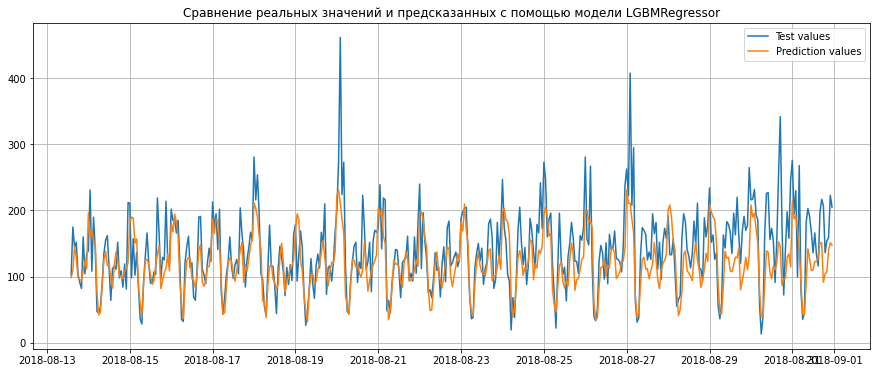

In [ ]:
plt.figure(figsize=(15, 6))
plt.title('Сравнение реальных значений и предсказанных с помощью модели LGBMRegressor')
plt.plot(target_test, label='Test values')
predictions = model_gbm_test.predict(features_test)
predictions = pd.Series(predictions, index=target_test.index)
plt.plot(predictions, label ='Prediction values')
plt.legend(loc='upper right')
plt.grid(True)

*Добавим данные RMSE на тестовой выборке в таблицу для визуального сравнения.*

In [ ]:
df_rmse['RMSE_test'] = [RMSE_lr_test, RMSE_rfr_test, RMSE_cbr_test, RMSE_gbm_test]
df_rmse

,RMSE,RMSE_test
LinearRegression,31.742917,51.192444
RandomForestRegressor,25.287766,47.106423
CatBoostRegressor,25.269630,46.546360
LGBMRegressor,25.156490,44.604563


**Вывод:**

* В ходе проекта были обработаны данные о заказах такси. Для прогноза количества заказов такси были построены 4 модели предскания: LinearRegression, RandomForestRegressor, CatBoostRegressor, LGBMRegressor.
* По итогу тестирования все модели, кроме LinearRegression, подошли под требование по поставленной метрике (RMSE < 48).
* Самые эффективные модели CatBoostRegressor и LGBMRegressor, но последняя дольше обучается.
* По параметрам метрики и скорости обучения модель CatBoostRegressor является лучшей.